### Basic settings

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.6.1 anndata==0.7.5 umap==0.4.6 numpy==1.19.5 scipy==1.5.3 pandas==1.1.5 scikit-learn==0.24.0 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3


In [35]:
save_dir='./' ## need to change the directory
sc.settings.figdir = save_dir

### Import data

The data could be downloaded from https://drive.google.com/drive/folders/1MZEaM28PHW4FTSKzy-h_OqPnSlRKiYKW?usp=sharing.

In [3]:
%%time
adata=sc.read('./Hochgerner_dentate_gyrus_QC.h5ad') ## need to change the directory

CPU times: user 174 ms, sys: 237 ms, total: 412 ms
Wall time: 410 ms


In [4]:
np.unique(adata.obs['CellTypes'])

array(['Astro-adult', 'Astro-juv', 'CA3-Pyr', 'Cajal-Retzius',
       'Endothelial', 'Ependymal', 'GABA', 'GC-adult', 'GC-juv',
       'Immature-Astro', 'Immature-GABA', 'Immature-GC', 'Immature-Pyr',
       'MOL', 'MiCajal-Retziusoglia', 'NFOL', 'Neuroblast', 'OPC', 'PVM',
       'RGL', 'RGL_young', 'VLMC', 'nIPC', 'nIPC-perin'], dtype=object)

In [5]:
len(np.unique(adata.obs['CellTypes']))

24

In [6]:
adata

AnnData object with n_obs × n_vars = 23025 × 19444
    obs: 'source name', 'organism', 'characteristics: strain', 'characteristics: age', 'characteristics: sex of pooled animals', 'characteristics: cell cluster', 'molecule', 'SRR run accession', 'raw file (original file name)', 'UMI_CellularBarcode', 'CellTypes', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'CellTypes_colors'

Note: the data is already filtered after proper quality control.

### Normalization

In [7]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


### HVG identification

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
3000


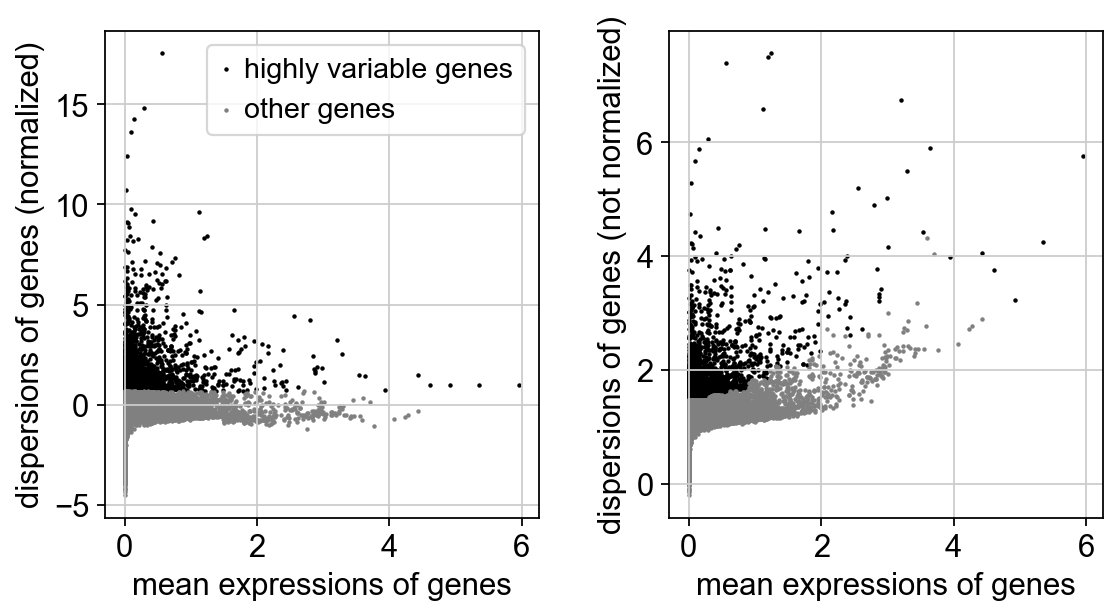

In [8]:
sc.pp.highly_variable_genes(adata,
                            n_top_genes=3000
                           )
print(sum(adata.var.highly_variable))
sc.pl.highly_variable_genes(adata)

### Run PCA

In [9]:
use_highly_variable=True
from sklearn.preprocessing import StandardScaler
expr = adata[:, adata.var['highly_variable']].X if use_highly_variable else adata.X
expr=StandardScaler(with_mean=False).fit_transform(expr)
expr[expr > 10] = 10
from sklearn.decomposition import TruncatedSVD
transformer = TruncatedSVD(n_components=50, random_state=42)
adata.obsm['X_pca']= transformer.fit_transform(expr)

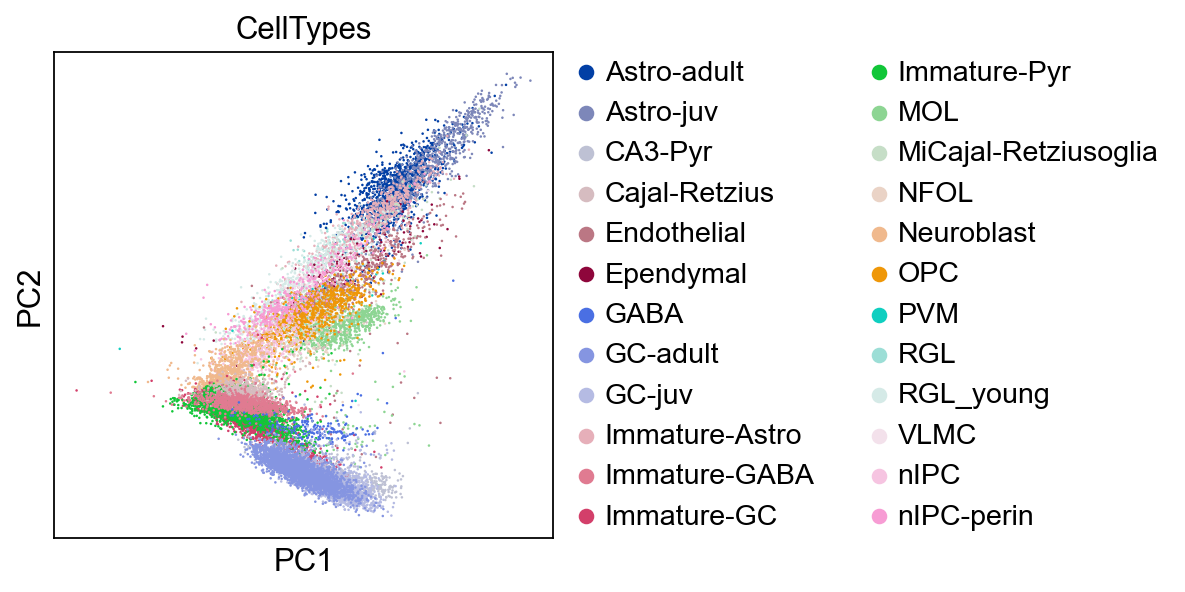

In [10]:
sc.pl.pca(adata,color='CellTypes')

### Reorder the CellTypes

In [11]:
%%time
sc.tl.dendrogram(adata,groupby='CellTypes',use_rep='X_pca')

Storing dendrogram info using `.uns["dendrogram_['CellTypes']"]`
CPU times: user 11.5 ms, sys: 3.96 ms, total: 15.4 ms
Wall time: 13.6 ms


In [12]:
celltype=adata.obs['CellTypes'].values.copy()
new_order=adata.uns["dendrogram_['CellTypes']"]['categories_ordered']
celltype=celltype.reorder_categories(new_order)

In [13]:
adata.obs['CellTypes']=celltype

### Run UMAP

In [14]:
%%time
sc.pp.neighbors(adata,
               n_neighbors=15,random_state=10,knn=True,
                method="umap")

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
CPU times: user 33.4 s, sys: 16 s, total: 49.4 s
Wall time: 20.9 s


In [15]:
%%time
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)
CPU times: user 57.5 s, sys: 2min 26s, total: 3min 23s
Wall time: 14.7 s


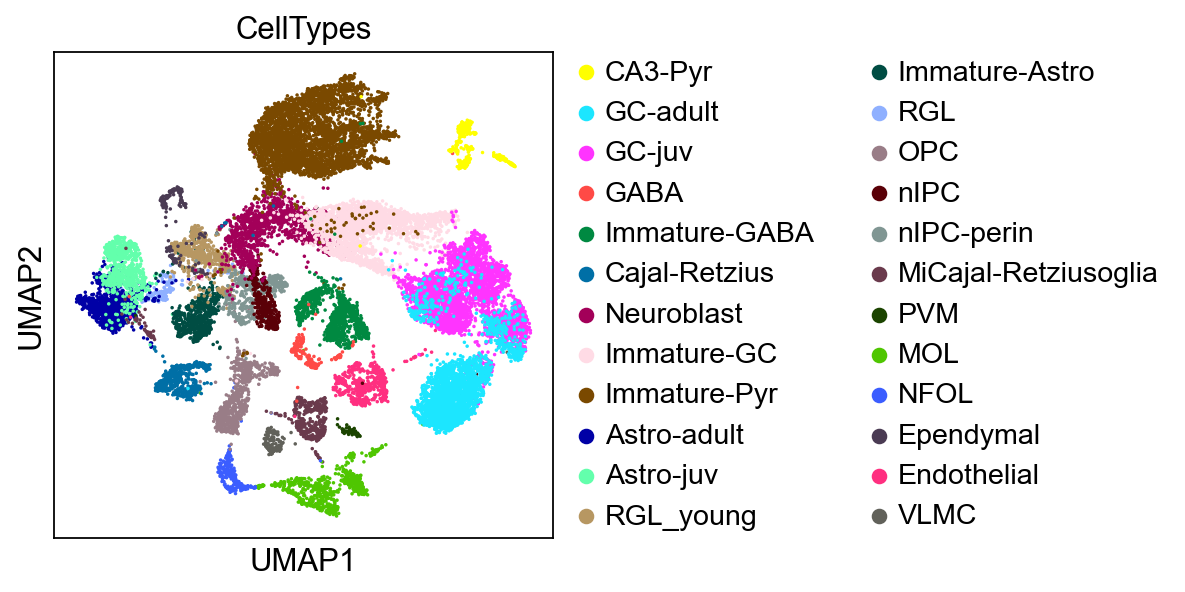

CPU times: user 1.34 s, sys: 48.9 ms, total: 1.38 s
Wall time: 1.38 s


In [16]:
%%time
sc.pl.umap(adata,
           color=['CellTypes'],
           palette=sc.pl.palettes.default_102,
           size=10,
           frameon=True)

### Marker gene identification

#### 1. COSG

Import COSG:

In [46]:
import cosg as cosg
import importlib
importlib.reload(cosg)

<module 'cosg' from '/platinum-2/daimin/analysis/jupyter/python/cosg.py'>

Print the usgae:

In [47]:
help(cosg.cosg)

Help on function cosg in module cosg:

cosg(adata, groupby='CellTypes', groups:Union[typing_extensions.Literal['all'], Iterable[str]]='all', mu=1, remove_lowly_expressed:bool=False, expressed_pct:Union[float, NoneType]=0.1, n_genes_user:int=50, key_added:Union[str, NoneType]=None, use_raw:bool=True, layer:Union[str, NoneType]=None, reference:str='rest', copy:bool=False)
    Marker gene identification for single-cell sequencing data using COSG.
    Parameters
    ----------
    adata
        Annotated data matrix. Note: input paramters are simliar to the parameters used for scanpy's rank_genes_groups() function.
    groupby
        The key of the cell groups in .obs, the default value is set to 'CellTypes'.
    groups
        Subset of cell groups, e.g. [`'g1'`, `'g2'`, `'g3'`], to which comparison shall be restricted. The default value is 'all', and all groups will be compared.
    mu
        The penalty restricting marker genes expressing in non-target cell groups. Larger value repres

In [49]:
%%time
import time
t0= time.clock()
cosg.cosg(adata,
    key_added='cosg',
        mu=1,
        n_genes_user=50,
               groupby='CellTypes')
runtime_cosg = time.clock() - t0

**finished identifying marker genes by COSG**
CPU times: user 2.7 s, sys: 343 ms, total: 3.04 s
Wall time: 3.04 s


In [50]:
sc.tl.dendrogram(adata,groupby='CellTypes',use_rep='X_pca')

Storing dendrogram info using `.uns["dendrogram_['CellTypes']"]`


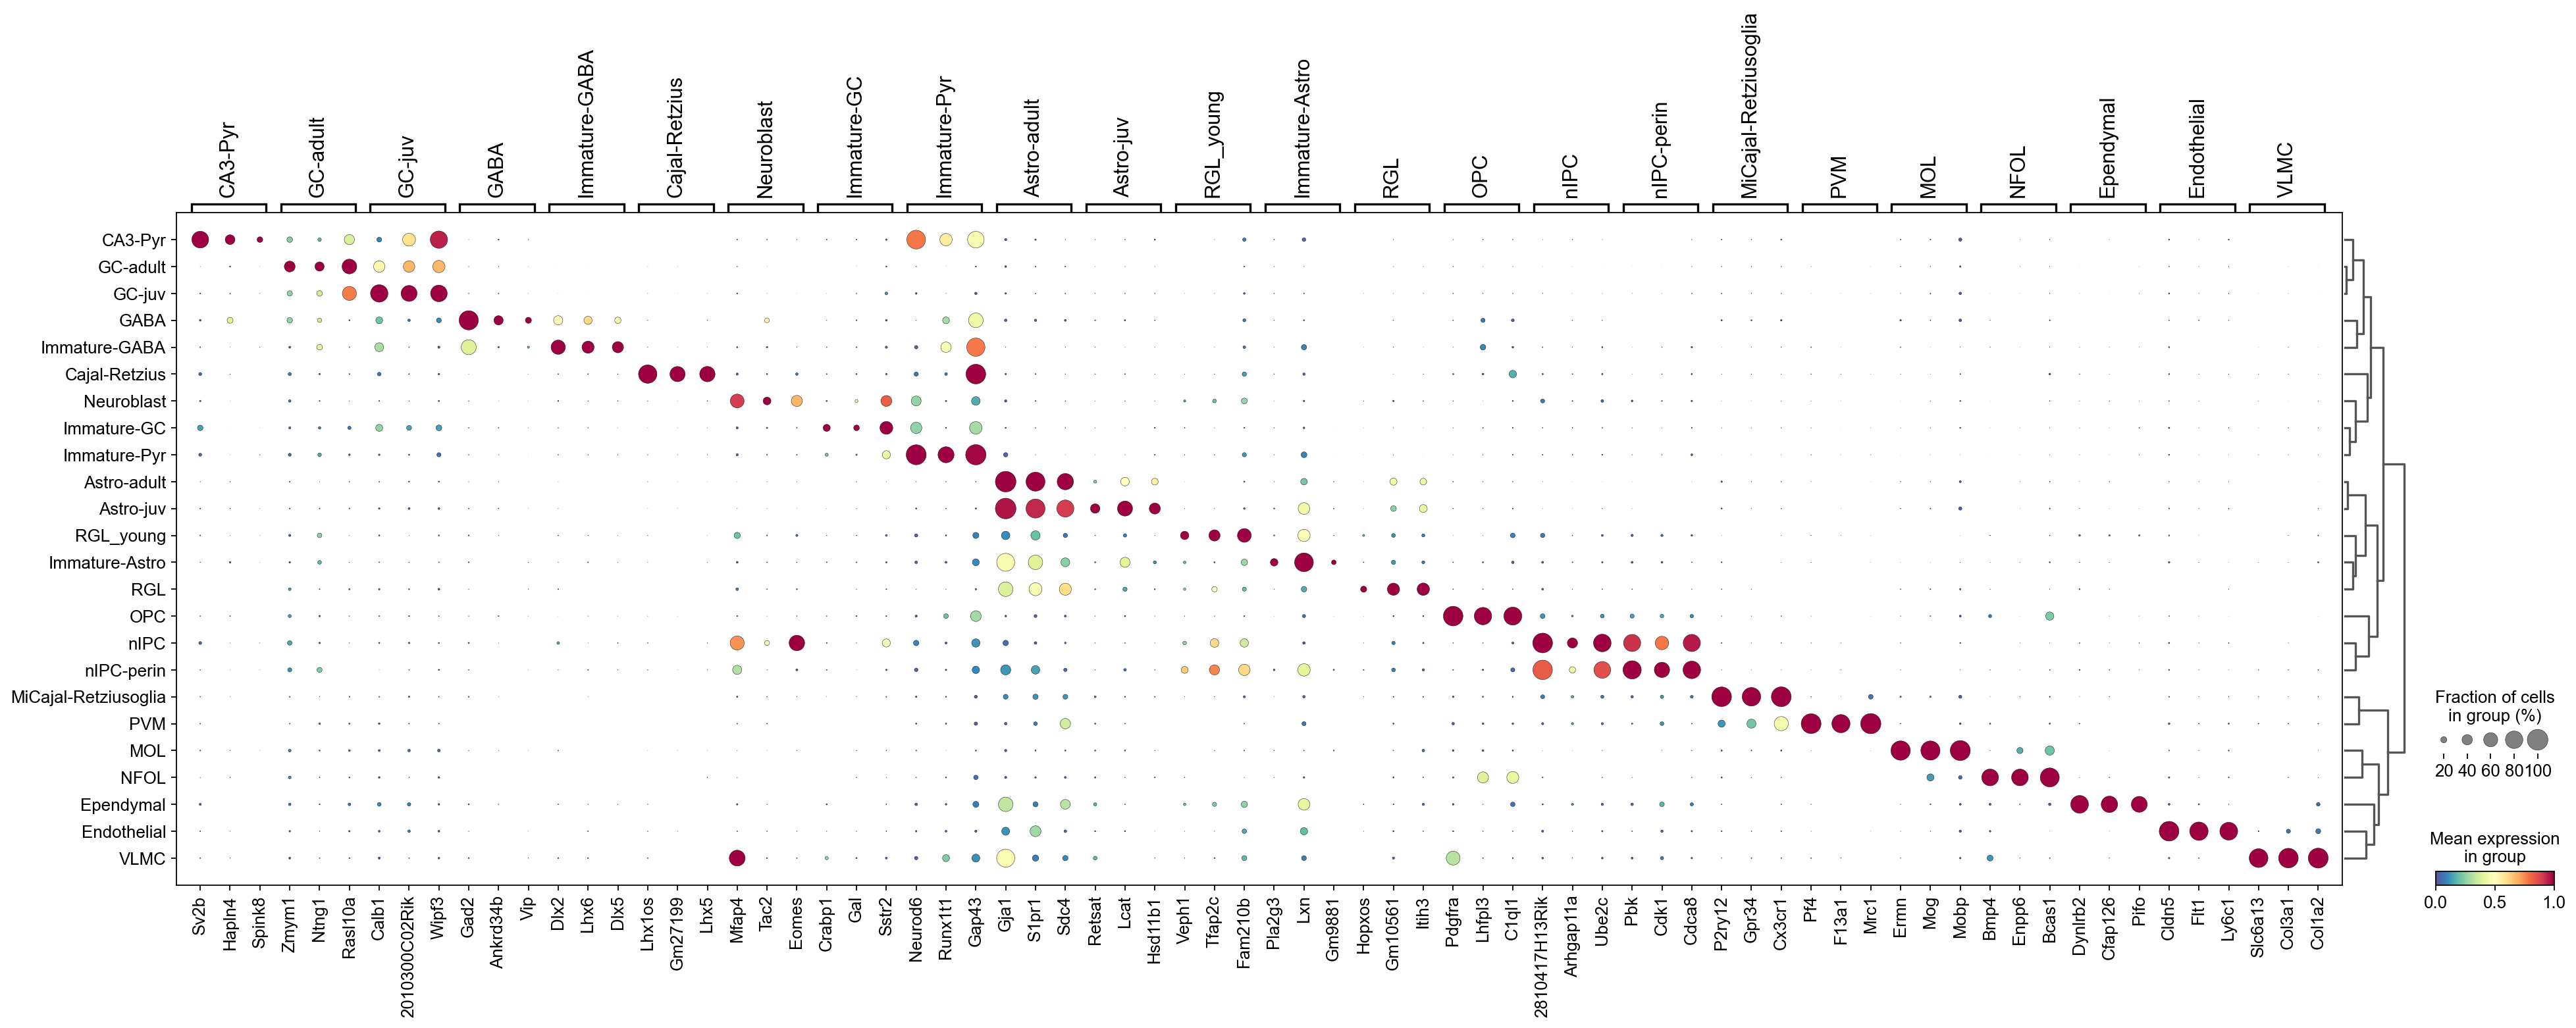

In [51]:
sc.pl.rank_genes_groups_dotplot(adata,groupby='CellTypes',
                                cmap='Spectral_r',
                                 standard_scale='var',
                                       n_genes=3,key='cosg')

#### 2. Logistic regression

In [29]:
%%time
t0= time.clock()
sc.tl.rank_genes_groups(adata,
                        groupby='CellTypes',
                        method='logreg',
                        key_added='logreg',
                        n_genes=50)
runtime_logreg = time.clock() - t0

ranking genes
    finished: added to `.uns['logreg']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:03:16)
CPU times: user 15min 34s, sys: 52min 18s, total: 1h 7min 52s
Wall time: 3min 16s


/platinum-2/daimin/software/miniconda3/envs/scda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


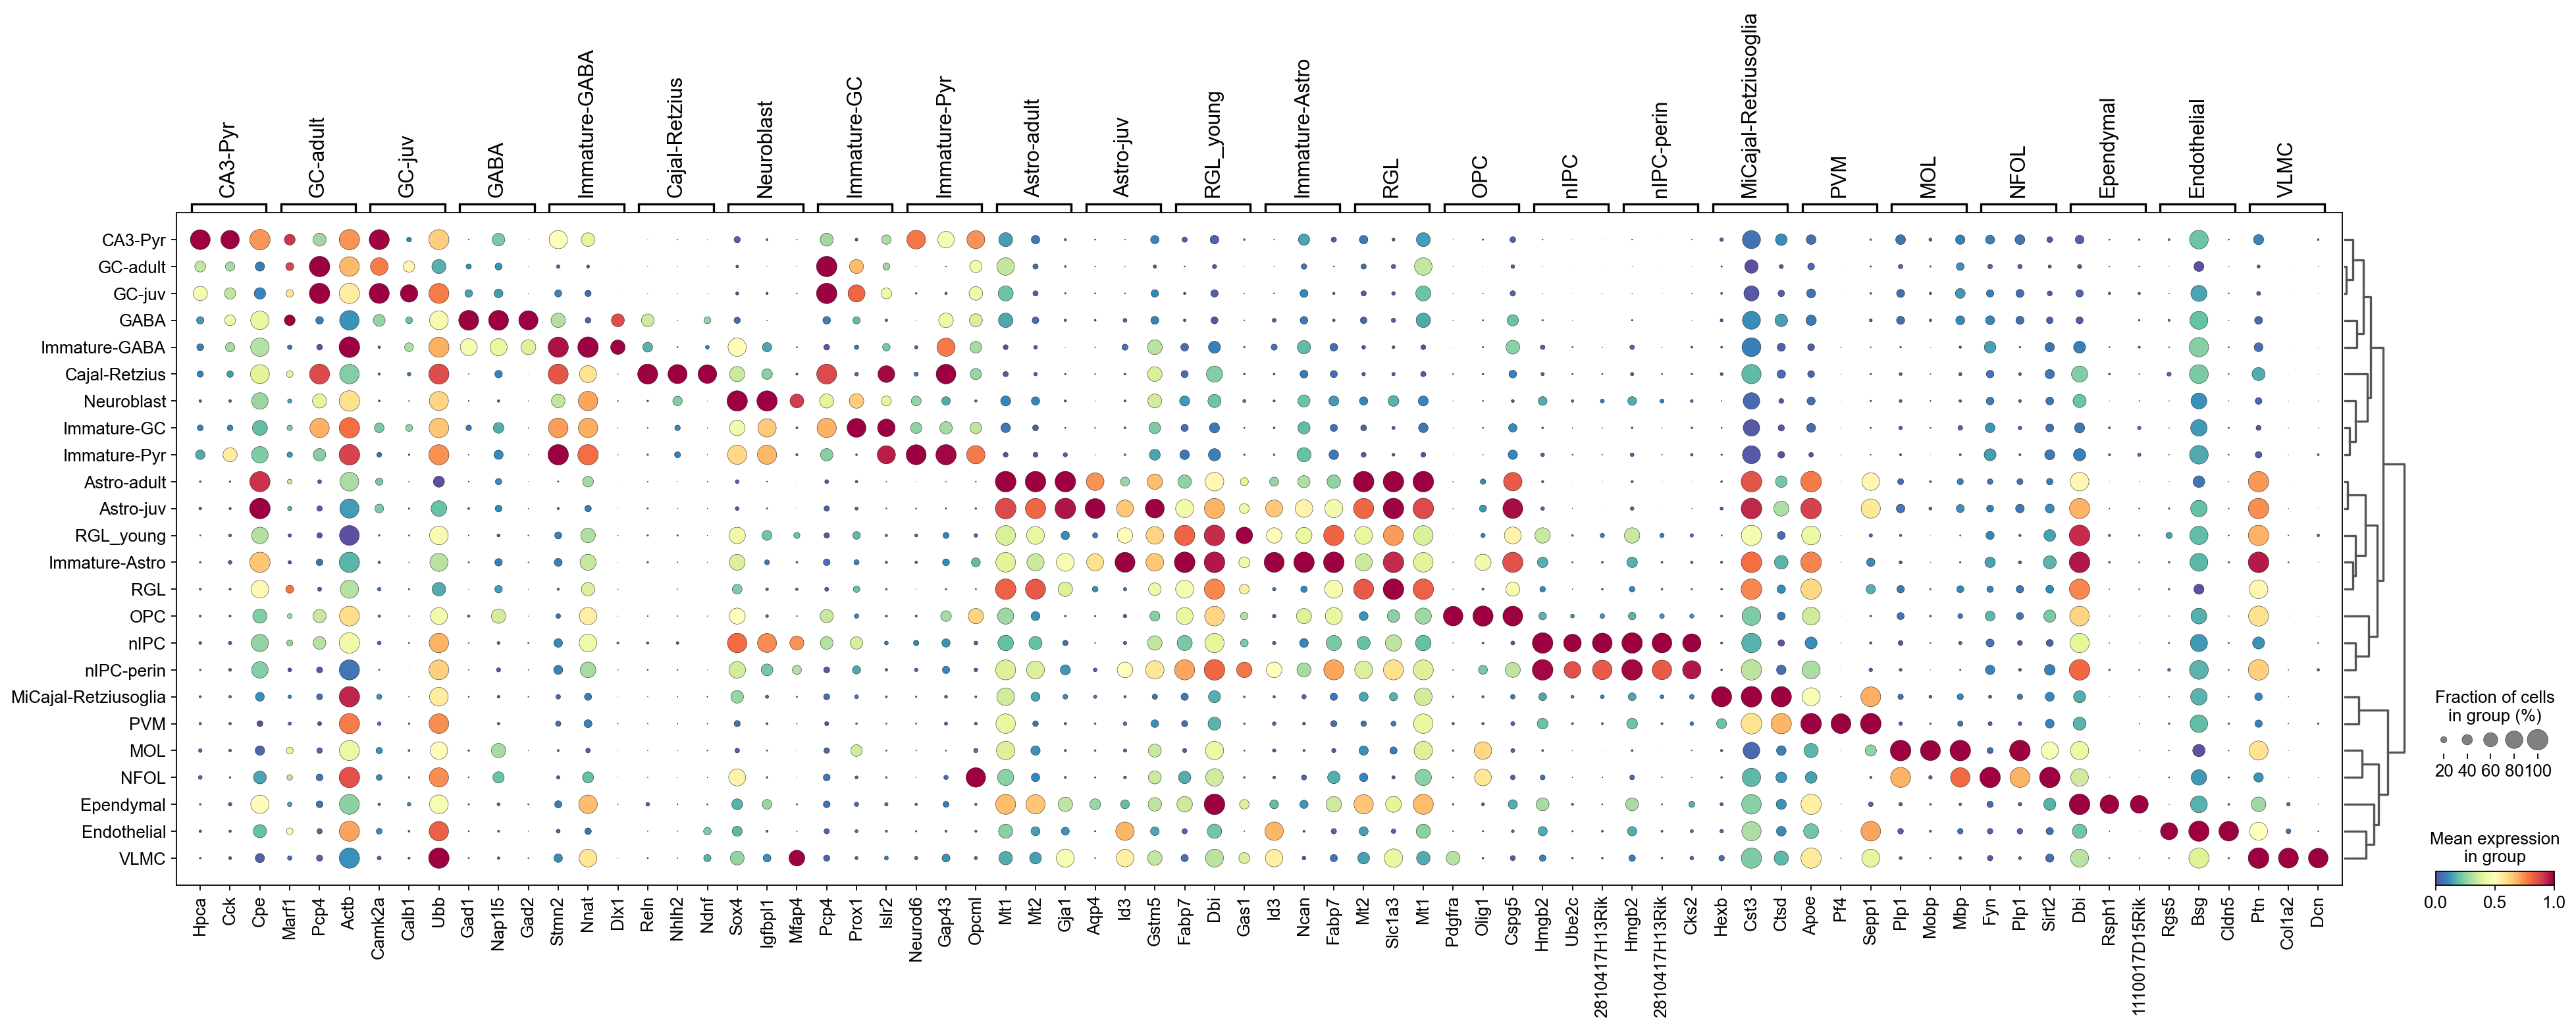

In [30]:
sc.pl.rank_genes_groups_dotplot(adata,groupby='CellTypes',
                                cmap='Spectral_r',
                                 standard_scale='var',
                                       n_genes=3,key='logreg')

#### 3. Wilcoxon-test

In [31]:
%%time
t0= time.clock()
sc.tl.rank_genes_groups(adata, groupby='CellTypes', 
                        tie_correct=False,
                        method='wilcoxon',
                        key_added='wilcoxon',n_genes=50)
runtime_wilcoxon= time.clock() - t0

ranking genes
    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:46)
CPU times: user 37.5 s, sys: 8.72 s, total: 46.2 s
Wall time: 46.2 s


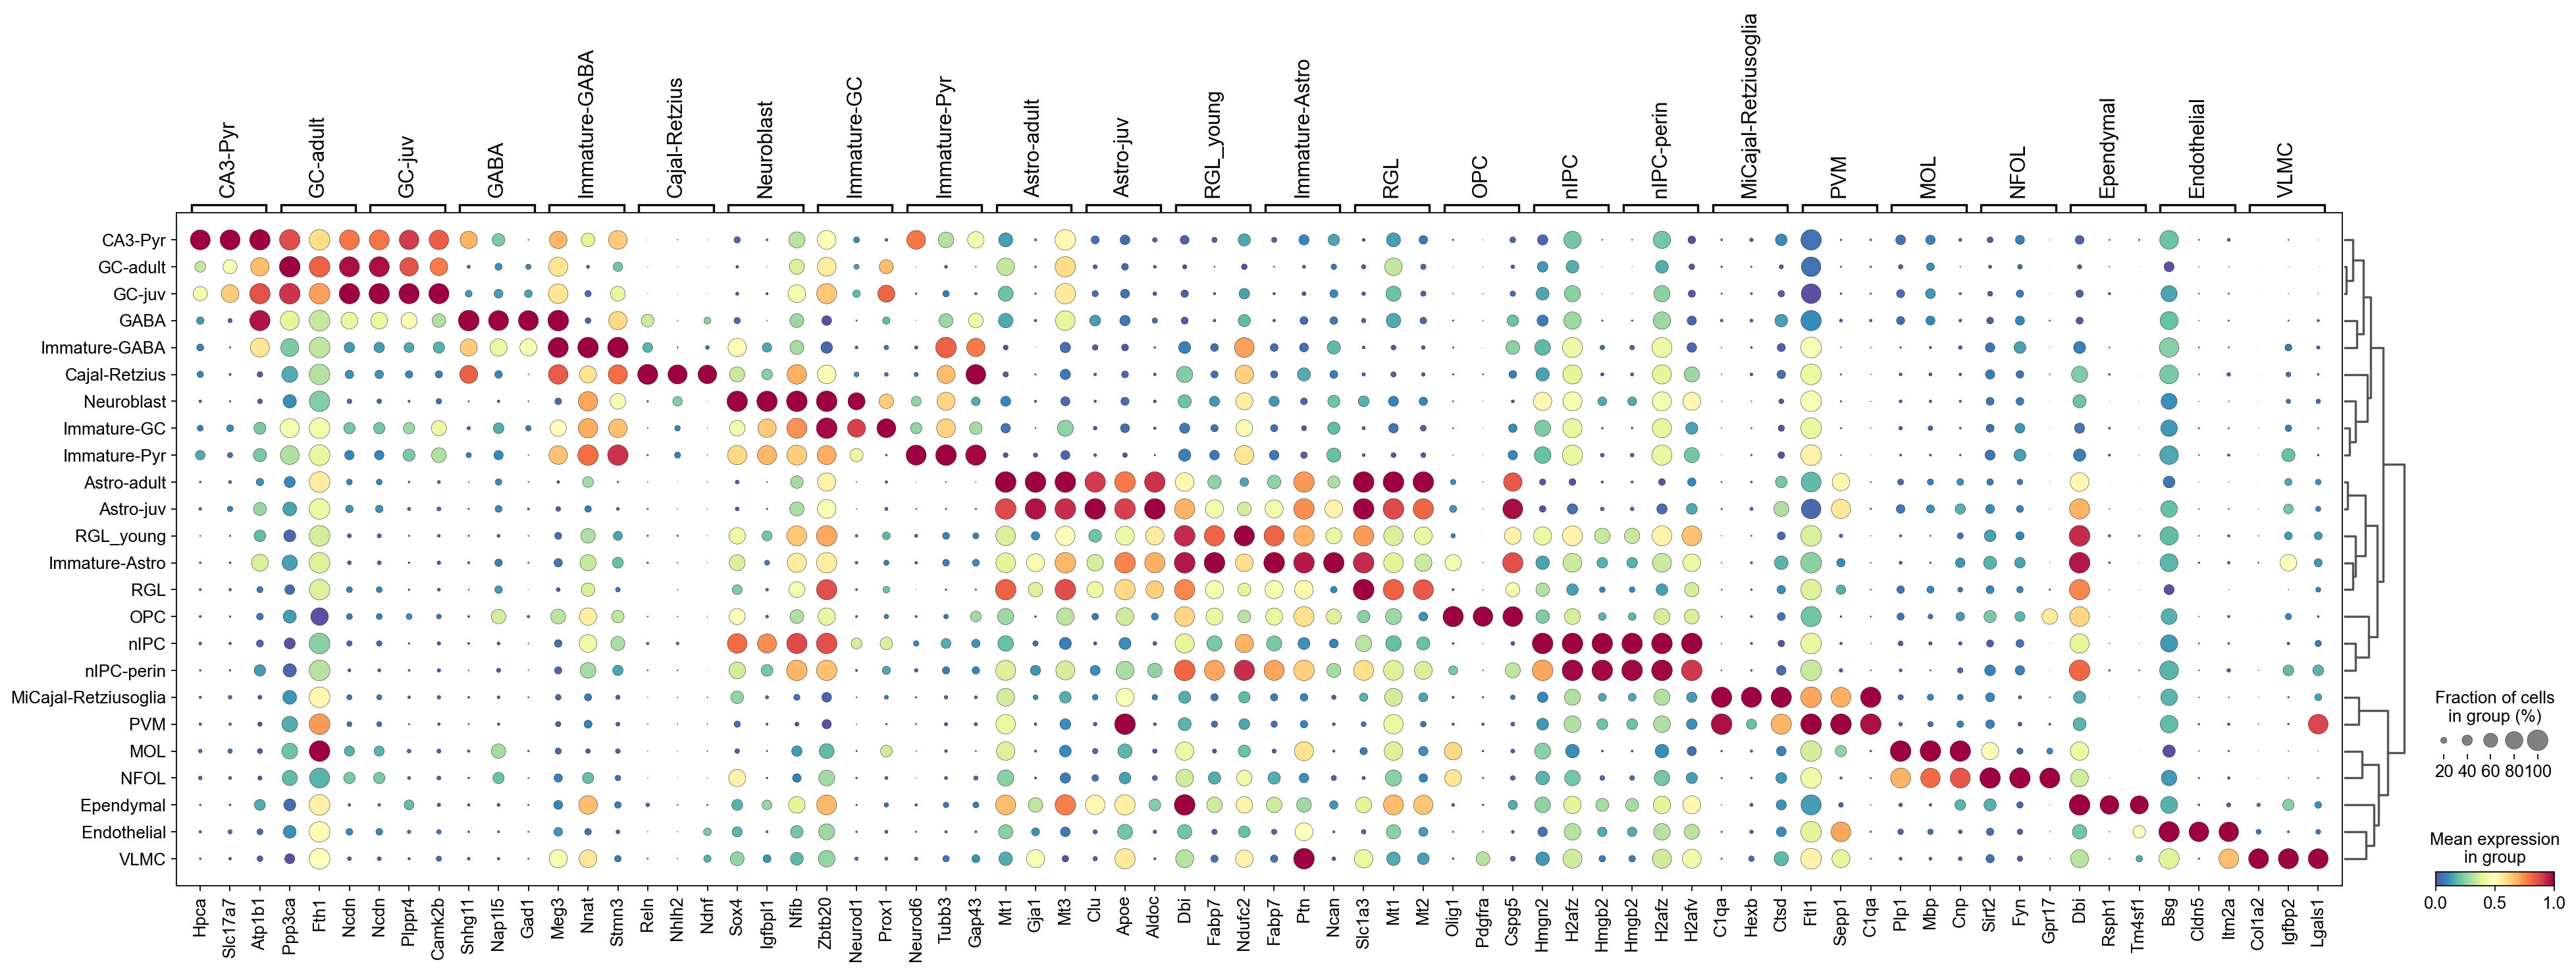

In [32]:
sc.pl.rank_genes_groups_dotplot(adata,groupby='CellTypes',
                                cmap='Spectral_r',
                                 standard_scale='var',
                                       n_genes=3,key='wilcoxon')

#### 4. Wilcoxon-test (TIE)

In [33]:
%%time
t0= time.clock()
sc.tl.rank_genes_groups(adata, groupby='CellTypes', 
                        tie_correct=True,
                        method='wilcoxon',
                        key_added='wilcoxon_tie',n_genes=50)
runtime_wilcoxon_tie = time.clock() - t0

ranking genes


/platinum-2/daimin/software/miniconda3/envs/scda3/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:313: RuntimeWarning: invalid value encountered in true_divide
  ) / std_dev


    finished: added to `.uns['wilcoxon_tie']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:15:23)
CPU times: user 12min 45s, sys: 2min 38s, total: 15min 23s
Wall time: 15min 23s


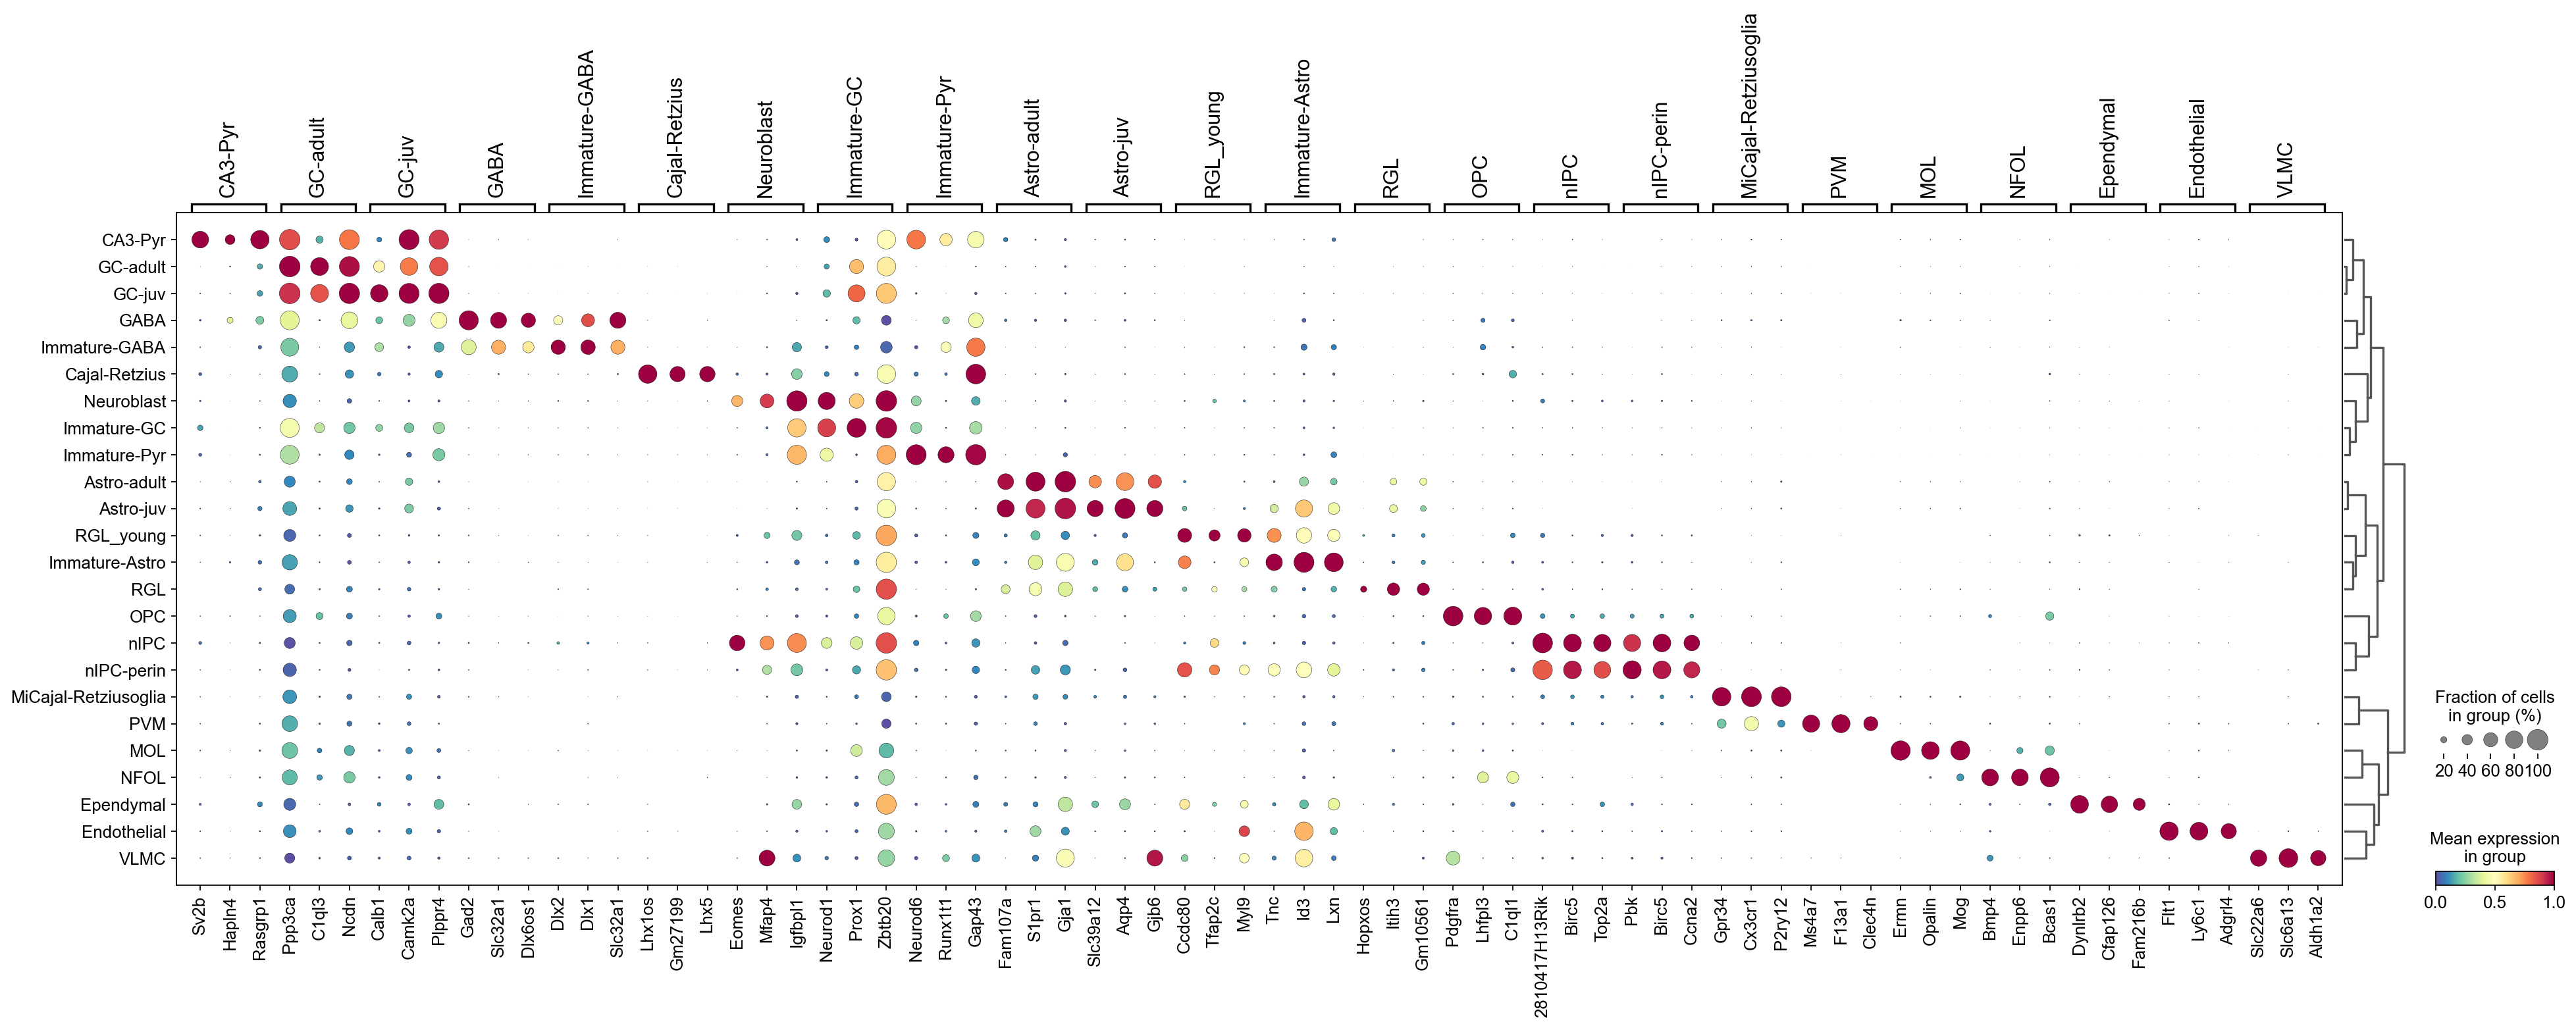

In [34]:
sc.pl.rank_genes_groups_dotplot(adata,groupby='CellTypes',
                                cmap='Spectral_r',
                                 standard_scale='var',
                                       n_genes=3,key='wilcoxon_tie')

### Runtime comparison

In [71]:
print( [runtime_logreg, runtime_wilcoxon, runtime_wilcoxon_tie, runtime_cosg] )

[4072.48, 46.220000000000255, 923.6999999999998, 3.0299999999997453]


### Violin plots

In [52]:
celltype_selected= 'GC-adult'

In [53]:
adata_selected=adata[adata.obs['CellTypes'].isin(['CA3-Pyr',  'GC-adult', 'GC-juv'])]

In [56]:
marker_violin=np.hstack([pd.DataFrame(adata.uns['logreg']['names'])[celltype_selected][:3].values,
pd.DataFrame(adata.uns['wilcoxon']['names'])[celltype_selected][:3].values,
pd.DataFrame(adata.uns['wilcoxon_tie']['names'])[celltype_selected][:3].values,
pd.DataFrame(adata.uns['cosg']['names'])[celltype_selected][:3].values])

In [57]:
marker_violin

array(['Marf1', 'Pcp4', 'Actb', 'Ppp3ca', 'Fth1', 'Ncdn', 'Ppp3ca',
       'C1ql3', 'Ncdn', 'Zmym1', 'Ntng1', 'Rasl10a'], dtype=object)

In [66]:
vp=sc.pl.stacked_violin(adata_selected, 
                     marker_violin,
                     groupby='CellTypes', 
                     swap_axes=True,
                     figsize=(4, 9),
                     scale='width',
                     yticklabels=True,
                     size=0.2,
                     inner='box',
                     cut=True,              
                     return_fig=True,
                    )

In [67]:
icolor=[ "#ffe119", # Logistic regression
                  "#e6194b",   # Wilcoxon-test
                 "#4363d8",  # Wilcoxon-test (TIE)
                    "#3cb44b" # COSG ,
       ]
icolor=np.hstack([np.repeat(i,3) for i in icolor])
icolor

array(['#ffe119', '#ffe119', '#ffe119', '#e6194b', '#e6194b', '#e6194b',
       '#4363d8', '#4363d8', '#4363d8', '#3cb44b', '#3cb44b', '#3cb44b'],
      dtype='<U7')

In [68]:
icolor=list(icolor)

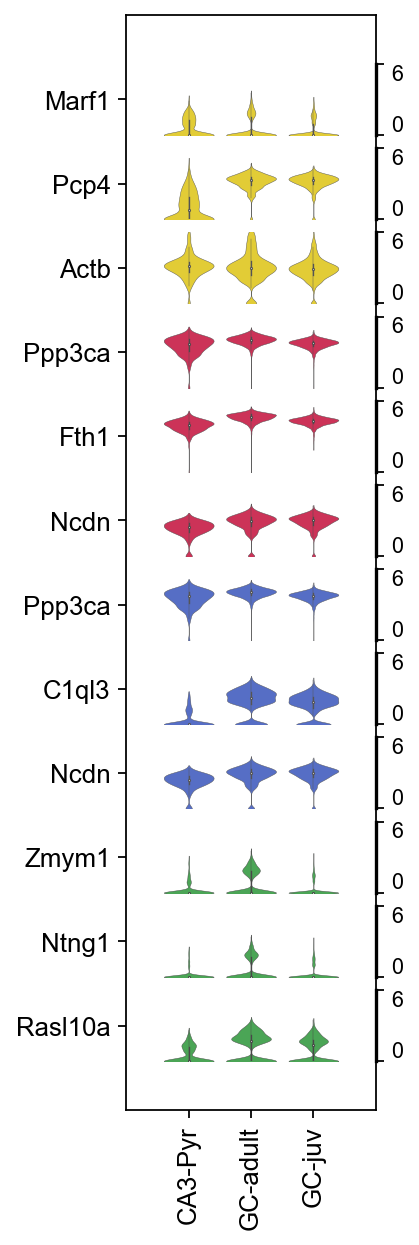

In [69]:
vp.style(ylim=(0,6),
         row_palette=icolor,yticklabels=True,).show()

### Save the data

In [36]:
adata.write(save_dir+'/COSG_tutorial_Hochgerner_dentate_gyrus_QC.h5ad')

### Contact

Min Dai, daimin@zju.edu.cn